In [1]:
#@title Import and Install Libraries { vertical-output: true, display-mode: "form" }
from IPython import display

# !pip install keras-layer-normalization
display.clear_output()
print("keras-layer-normalization library is installed successfully")
print()
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import tensorflow as tf
import cv2
import os
import keras
import time 
import shutil
import csv
import imageio
import scipy.io

from sklearn.metrics import roc_auc_score
from tensorflow.keras.layers import Conv3D, MaxPooling3D, BatchNormalization, Flatten, Dense, Dropout, Reshape, Conv3DTranspose, UpSampling3D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from matplotlib.animation import FuncAnimation, writers
import matplotlib.patches as mpatches
import glob
from os.path import isfile, join, isdir
from PIL import Image
from tqdm import tqdm
from IPython.display import HTML
print("All librairies are imported successfully")

keras-layer-normalization library is installed successfully



2023-06-09 02:05:33.178917: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 02:05:34.129184: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


All librairies are imported successfully


In [2]:
# Defining  Paths and Parameters

import os

class Path :

  def __init__(self, choice) :
    root_dir = "path/to/project/"
    expr_dir = root_dir + "Experiments/Video-AD/Trad_VAD_CNN/"
    data_dir = root_dir + "datasets/"

    if (choice == "ped1") :
      self.train = data_dir + "UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train"
      self.test = data_dir + "UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test"
      self.fps = 13
    elif (choice == "ped2"):
      self.train = data_dir + "UCSD_Anomaly_Dataset.v1p2/UCSDped2/Train"
      self.test = data_dir + "UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test"
      self.fps = 26
    elif choice == "avenue" :
      self.train = data_dir + "Avenue Dataset/training_videos"
      self.test = data_dir + "Avenue Dataset/testing_videos"
    elif choice == "shanghaitech" :
      self.train = data_dir + "Shanghaitech/taining/videos"
      self.test = data_dir + "Shanghaitech/testing/frames"
      self.fps = 25

    self.result = expr_dir + "Results/"+choice
    self.model = expr_dir + "Models/"+choice+"/{}.hdf5"    ## Ex : cla.hdf5
    self.history = expr_dir + "History/"+choice+"/{}_history_log.csv"     ## Ex : cla_history_log.csv
    self.checkpoint = expr_dir + "Checkpoint/"+choice+"/checkpoint-{epoch:02d}-{loss:.4f}.hdf5"      ## Ex : checkpoint-cla-40-001.hdf5
    self.video = expr_dir + "Videos/"+choice       
    self.loss = expr_dir + "Images/"+choice+"/Loss/{}-{}-epochs.png"      ## Ex : cla-50-epochs.png
    self.regularity = expr_dir + "Images/"+choice+"/Regularity/Test{}-{}.png"       ## Ex : Test8-cla.png
    self.auc = expr_dir + "Images/"+choice+"/auc/auc-{}.png"        ## Ex : auc-cla.png
    self.plot = expr_dir + "Images/{}.png"        ## Ex : cla.png
    self.recon_img = expr_dir + "Images/"+choice+"/Reconstructed_images/"

    # Check if directories exist, if not, create them
    if not os.path.exists(self.result):
      os.makedirs(self.result)
    if not os.path.exists(self.video):
      os.makedirs(self.video)
    if not os.path.exists(os.path.dirname(self.history)):
      os.makedirs(os.path.dirname(self.history))
    if not os.path.exists(os.path.dirname(self.checkpoint)):
      os.makedirs(os.path.dirname(self.checkpoint))
    if not os.path.exists(os.path.dirname(self.loss)):
      os.makedirs(os.path.dirname(self.loss))
    if not os.path.exists(os.path.dirname(self.regularity)):
      os.makedirs(os.path.dirname(self.regularity))
    if not os.path.exists(os.path.dirname(self.auc)):
      os.makedirs(os.path.dirname(self.auc))
    if not os.path.exists(os.path.dirname(self.plot)):
      os.makedirs(os.path.dirname(self.plot))
    if not os.path.exists(os.path.dirname(self.recon_img)):
      os.makedirs(os.path.dirname(self.recon_img))

print("Paths and Parameters are defined successfully")

Paths and Parameters are defined successfully


### Model creation

#### C3D-AE Model Creation

#### 0th model with less parameters

In [6]:
def create_3D_CNN_AE(input_shape=(16, 224, 224, 1)):
    model = Sequential(name="3D-CNN-AE")

    # Build encoder
    model.add(Conv3D(32, (5, 5, 5), activation='relu', padding='same', input_shape=input_shape, name='encoder_conv1'))
    model.add(BatchNormalization(name='encoder_batchnorm1'))
    model.add(MaxPooling3D((2, 2, 2), padding='same', name='encoder_maxpool1'))
    model.add(Dropout(0.25))

    model.add(Conv3D(64, (5, 5, 5), activation='relu', padding='same', name='encoder_conv2'))
    model.add(BatchNormalization(name='encoder_batchnorm2'))
    model.add(MaxPooling3D((2, 2, 2), padding='same', name='encoder_maxpool2'))
    model.add(Dropout(0.25))

    model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same', name='encoder_conv3'))
    model.add(BatchNormalization(name='encoder_batchnorm3'))
    model.add(MaxPooling3D((2, 2, 2), padding='same', name='encoder_maxpool3'))
    model.add(Dropout(0.25))

    model.add(Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='encoder_conv4'))
    model.add(BatchNormalization(name='encoder_batchnorm4'))
    model.add(MaxPooling3D((2, 2, 2), padding='same', name='encoder_maxpool4'))
    model.add(Dropout(0.25))

    # Build decoder
    model.add(Conv3DTranspose(256, (3, 3, 3), activation='relu', strides=(2, 2, 2), padding='same', input_shape=(2, 2, 2, 256), name='decoder_conv1'))
    model.add(BatchNormalization(name='decoder_batchnorm1'))
    # model.add(UpSampling3D((2, 2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv3DTranspose(128, (3, 3, 3), activation='relu', strides=(2, 2, 2), padding='same', name='decoder_conv2'))
    model.add(BatchNormalization(name='decoder_batchnorm2'))
    model.add(Dropout(0.25))

    model.add(Conv3DTranspose(64, (5, 5, 5), activation='relu', strides=(2, 2, 2), padding='same', name='decoder_conv3'))
    model.add(BatchNormalization(name='decoder_batchnorm3'))
    model.add(Dropout(0.25))

    model.add(Conv3DTranspose(32, (5, 5, 5), activation='relu', strides=(2, 2, 2), padding='same', name='decoder_conv4'))
    model.add(BatchNormalization(name='decoder_batchnorm4'))
    model.add(Dropout(0.25))

    model.add(Conv3DTranspose(1, (3, 3, 3), activation='tanh', padding='same', name='decoder_output'))



    return model


print("3D-CNN-AE Model has created successfully")
input_shape = (16, 224, 224, 1)
model = create_3D_CNN_AE(input_shape)
model.summary()


3D-CNN-AE Model has created successfully


2023-06-08 21:41:34.252003: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 21:41:34.252306: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 21:41:34.274621: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "3D-CNN-AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_conv1 (Conv3D)      (None, 16, 224, 224, 32)  4032      
                                                                 
 encoder_batchnorm1 (BatchNo  (None, 16, 224, 224, 32)  128      
 rmalization)                                                    
                                                                 
 encoder_maxpool1 (MaxPoolin  (None, 8, 112, 112, 32)  0         
 g3D)                                                            
                                                                 
 dropout (Dropout)           (None, 8, 112, 112, 32)   0         
                                                                 
 encoder_conv2 (Conv3D)      (None, 8, 112, 112, 64)   256064    
                                                                 
 encoder_batchnorm2 (BatchNo  (None, 8, 112, 112, 64)  25

#### 1th model with more parameters

In [3]:
def create_3D_CNN_AE(input_shape=(16, 224, 224, 1)):
    model = Sequential(name="3D-CNN-AE")

    # Build encoder
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same', input_shape=input_shape, name='encoder_conv1'))
    model.add(BatchNormalization(name='encoder_batchnorm1'))
    model.add(MaxPooling3D((2, 2, 2), padding='same', name='encoder_maxpool1'))
    model.add(Dropout(0.2))

    model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same', name='encoder_conv2'))
    model.add(BatchNormalization(name='encoder_batchnorm2'))
    model.add(MaxPooling3D((2, 2, 2), padding='same', name='encoder_maxpool2'))
    model.add(Dropout(0.2))

    model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same', name='encoder_conv3'))
    model.add(BatchNormalization(name='encoder_batchnorm3'))
    model.add(MaxPooling3D((2, 2, 2), padding='same', name='encoder_maxpool3'))
    model.add(Dropout(0.2))

    model.add(Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='encoder_conv4'))
    model.add(BatchNormalization(name='encoder_batchnorm4'))
    model.add(MaxPooling3D((2, 2, 2), padding='same', name='encoder_maxpool4'))
    model.add(Dropout(0.2))

    model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='encoder_conv5'))
    model.add(BatchNormalization(name='encoder_batchnorm5'))
    # model.add(MaxPooling3D((2, 2, 2), padding='same', name='encoder_maxpool5'))
    model.add(Dropout(0.2))

    # Build decoder
    model.add(Conv3DTranspose(512, (3, 3, 3), activation='relu', strides=(2, 2, 2), padding='same', input_shape=(2, 2, 2, 512), name='decoder_conv1'))
    model.add(BatchNormalization(name='decoder_batchnorm1'))
    model.add(UpSampling3D((1, 1, 1)))
    model.add(Dropout(0.2))

    model.add(Conv3DTranspose(256, (3, 3, 3), activation='relu', strides=(2, 2, 2), padding='same', name='decoder_conv2'))
    model.add(BatchNormalization(name='decoder_batchnorm2'))
    model.add(Dropout(0.2))

    model.add(Conv3DTranspose(128, (3, 3, 3), activation='relu', strides=(2, 2, 2), padding='same', name='decoder_conv3'))
    model.add(BatchNormalization(name='decoder_batchnorm3'))
    model.add(Dropout(0.2))

    model.add(Conv3DTranspose(64, (5, 5, 5), activation='relu', padding='same', name='decoder_conv4'))
    model.add(BatchNormalization(name='decoder_batchnorm4'))
    model.add(Dropout(0.2))

    model.add(Conv3DTranspose(32, (3, 3, 3), activation='relu', strides=(2, 2, 2), padding='same', name='decoder_conv5'))
    model.add(BatchNormalization(name='decoder_batchnorm5'))
    model.add(Dropout(0.2))

    model.add(Conv3DTranspose(1, (3, 3, 3), activation='tanh', padding='same', name='decoder_output'))



    return model


print("3D-CNN-AE Model has created successfully")
input_shape = (16, 224, 224, 1)
model = create_3D_CNN_AE(input_shape)
model.summary()


3D-CNN-AE Model has created successfully


2023-06-09 02:05:47.010836: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-09 02:05:47.011271: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-09 02:05:47.043250: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "3D-CNN-AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_conv1 (Conv3D)      (None, 16, 224, 224, 32)  896       
                                                                 
 encoder_batchnorm1 (BatchNo  (None, 16, 224, 224, 32)  128      
 rmalization)                                                    
                                                                 
 encoder_maxpool1 (MaxPoolin  (None, 8, 112, 112, 32)  0         
 g3D)                                                            
                                                                 
 dropout (Dropout)           (None, 8, 112, 112, 32)   0         
                                                                 
 encoder_conv2 (Conv3D)      (None, 8, 112, 112, 64)   55360     
                                                                 
 encoder_batchnorm2 (BatchNo  (None, 8, 112, 112, 64)  25

#### Loss function : Reconstruction loss

In [4]:
def reconstruction_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

### Train the model

In [ ]:
def training_model(model, model_name, training_set, batch_size, epochs, option, num_gpus=1):
    cp_callback = ModelCheckpoint(filepath=paths.checkpoint,
                                                     monitor='loss',
                                                     save_weights_only=True,
                                                     verbose=1)
    
    # create the csv logger and file if it does not exist
    if not os.path.exists(paths.history.format(model_name)):
        with open(paths.history.format(model_name), mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['epoch', 'train_loss'])
    csv_logger = CSVLogger(paths.history.format(model_name), append=True)
    
    if option == "Load":
        print("# Loading Model ...")
        model = load_model(paths.model.format(model_name), custom_objects={'reconstruction_loss': reconstruction_loss})
        print("# Model Loaded")
        with open(paths.history.format(model_name), newline='') as history:
            data = list(csv.reader(history))
        init_epoch = max([int(data[i][0]) for i in range(1, len(data))]) + 1
    
    elif option == "Create":
        print("# Creating Model ...")
        strategy = tf.distribute.MirroredStrategy(devices=["/gpu:%d" % i for i in range(num_gpus)])
        with strategy.scope():
            model = create_3D_CNN_AE()
            model.compile(loss=reconstruction_loss, optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True))
        init_epoch = 0
        print("# Model Created")

    # early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)
    start = time.time()
    print("# Training Model ...")
    history = model.fit(training_set, training_set, batch_size=batch_size, epochs=init_epoch+epochs, shuffle=False, callbacks=[cp_callback, csv_logger], initial_epoch=init_epoch)
    print("# Model Trained after %ds" % round(time.time() - start))

    print("# Saving Model ...")
    model.save(paths.model.format(model_name))
    print("# Model Saved to", paths.model.format(model_name))

    return history



# Creating Model ...
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:

2023-05-15 17:56:04.749200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [408,16,224,224,1]
	 [[{{node Placeholder/_10}}]]
2023-05-15 17:56:04.749459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [408,16,224,224,1]
	 [[{{node Placeholder/_11}}]]


INFO:tensorflow:batch_all_reduce: 42 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 42 all-reduces with algorithm = nccl, num_packs = 1


2023-05-15 17:56:08.817533: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-15 17:56:09.301477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-15 17:56:12.972015: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f6f1192cdb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-15 17:56:12.972039: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-05-15 17:56:12.972045: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-05-15 17:56:13.038279: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


102/102 [==============================] - ETA: 0s - loss: 0.1336
Epoch 1: saving model to /mnt/db5ee27b-d60f-427d-a8d7-117198a38bb1/Supriyo/Dissertation works/Experiments/Video-AD/SIVAD/Trad_VAD_CNN/Checkpoint/ped1/checkpoint-01-0.1336.hdf5
102/102 [==============================] - 43s 337ms/step - loss: 0.1336
Epoch 2/50
102/102 [==============================] - ETA: 0s - loss: 0.0358
Epoch 2: saving model to /mnt/db5ee27b-d60f-427d-a8d7-117198a38bb1/Supriyo/Dissertation works/Experiments/Video-AD/SIVAD/Trad_VAD_CNN/Checkpoint/ped1/checkpoint-02-0.0358.hdf5
102/102 [==============================] - 35s 340ms/step - loss: 0.0358
Epoch 3/50
102/102 [==============================] - ETA: 0s - loss: 0.0239
Epoch 3: saving model to /mnt/db5ee27b-d60f-427d-a8d7-117198a38bb1/Supriyo/Dissertation works/Experiments/Video-AD/SIVAD/Trad_VAD_CNN/Checkpoint/ped1/checkpoint-03-0.0239.hdf5
102/102 [==============================] - 35s 346ms/step - loss: 0.0239
Epoch 4/50
102/102 [=============

### For now we will only build the model for UCSD Ped dataset

### Ped1

In [9]:
# Choice of Dataset
choice =  "ped1" # param : {"ped1", "ped2"}
paths = Path(choice)

#### Data preprocessing

In [6]:
## Data preparations
# Creating clips from the frames

def get_clips(frames_list, seq_len):
    clips = []
    clip = np.zeros(shape=(seq_len, 224, 224, 1))
    for i, frame in enumerate(frames_list):
            clip[i % seq_len, :, :, 0] = frame
            if (i + 1) % seq_len == 0:
                clips.append(np.copy(clip))

    return clips


def import_data(path):
    clips = []
    for dir_path in sorted(glob.glob(path + "/*/")):
        # print("# Importing " + dir_path)
        all_frames = []
        for img_path in sorted(glob.glob(dir_path + "*.tif")):
            img = Image.open(img_path).resize((224, 224))
            img = np.array(img, dtype=np.float32) / 256.0
            all_frames.append(img)
        clips.extend(get_clips(frames_list=all_frames, seq_len=16)) # increasing sequence length to 16 for 3D CNN
    print("Importing of the frames has completed")
    return clips

print("Reading frames from video folders...")
training_set = np.array(import_data(paths.train))
print("Trainning Set is imported successfully \n")
print("Trainning Set Shape = ",training_set.shape)

Reading frames from video folders...
Importing of the frames has completed
Trainning Set is imported successfully 

Trainning Set Shape =  (408, 16, 224, 224, 1)


#### Free up the GPU memory

In [8]:
# !pip install numba

# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()

#### Train on Ped1 dataset

In [ ]:
model_name = "3D_CNN_AE"
option = 'Create' # param : {"Create", "Load"}
batch_size = 4
number_epochs = 50 # {type:"integer"}
num_gpus = 2 # {type:"integer"}

history = training_model(model, model_name, training_set, batch_size, number_epochs, option, num_gpus)


#### Plot the training loss

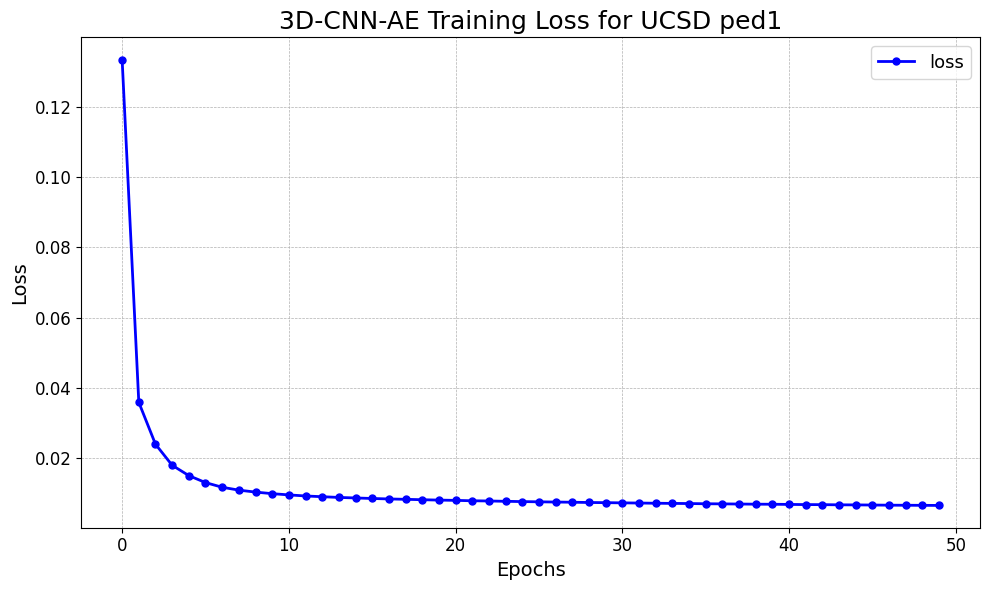

In [4]:
model_name = "3D_CNN_AE"
with open(paths.history.format(model_name), newline='') as history:
    data = list(csv.reader(history))
loss = np.array([float(data[i][1]) for i in range (1, len(data))])
epochs = np.array([int(data[i][0]) for i in range (1, len(data))])

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, '-o', color='blue', linewidth=2, markersize=5, label='loss')
plt.title('3D-CNN-AE Training Loss for UCSD ped1', fontsize=18)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(linestyle='--', linewidth=0.5)
plt.legend(loc='best', fontsize=13)
plt.tight_layout()
plt.savefig(paths.loss.format(model_name, max(epochs)+1), dpi=300)
plt.show()


### Other task

#### Visualization of 3D-CNN-AE model architecture

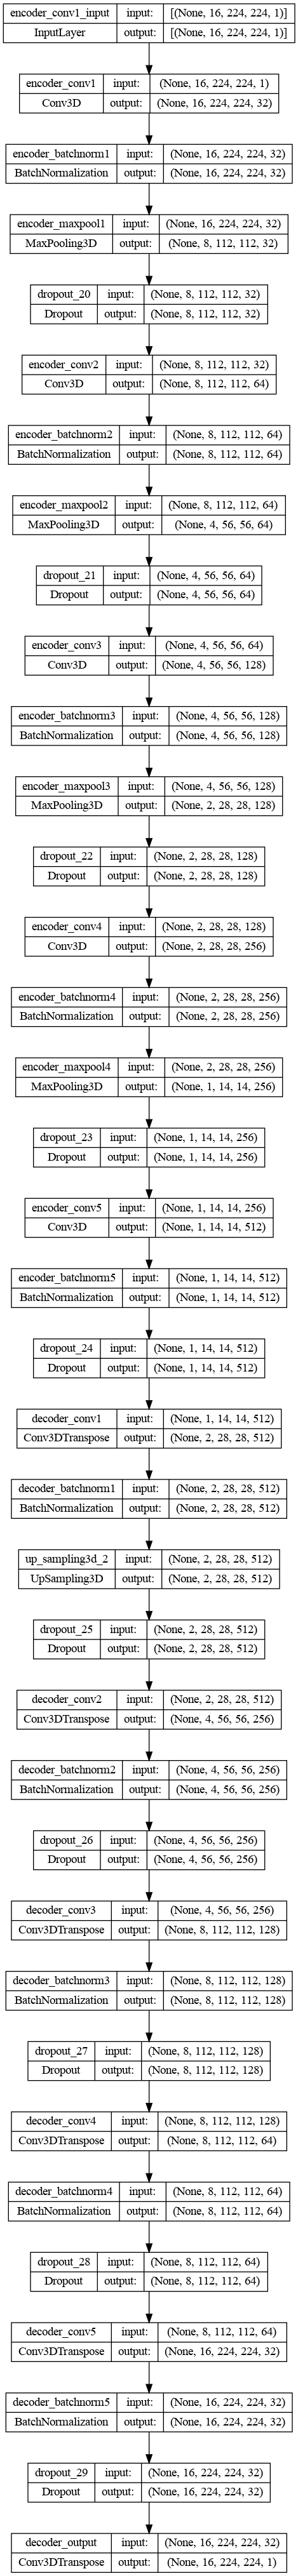

In [84]:
# !pip install pydot 
# !sudo apt install graphviz

model = load_model(paths.model.format(model_name), custom_objects={'reconstruction_loss': reconstruction_loss})
plot_model(model, to_file=paths.plot.format(model_name), show_shapes=True, show_layer_names=True, rankdir="TB")

In [85]:
# !pip install keras_sequential_ascii
from keras_sequential_ascii import keras2ascii
display.clear_output()
keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     16  224  224    1
              Conv3D    \|/  -------------------       896     0.0%
                relu   #####     16  224  224   32
  BatchNormalization    μ|σ  -------------------       128     0.0%
                       #####     16  224  224   32
        MaxPooling3D   Y max -------------------         0     0.0%
                       #####      8  112  112   32
             Dropout    | || -------------------         0     0.0%
                       #####      8  112  112   32
              Conv3D    \|/  -------------------     55360     0.3%
                relu   #####      8  112  112   64
  BatchNormalization    μ|σ  -------------------       256     0.0%
                       #####      8  112  112   64
        MaxPooling3D   Y max -------------------         0     0.0%
                       #####      4   56   56   64
             Dropout    | || -------------

### Inference

In [12]:
def reconstruct_test(model_name, test_num, num_gpus=1):
    model = load_model(paths.model.format(model_name), custom_objects={'reconstruction_loss': reconstruction_loss})
    print("Loaded model")
    
    test_path = os.path.join(paths.test, "Test{}".format(test_num))
    file_list = glob.glob(os.path.join(test_path, "*.tif"))
    num_frames = len(file_list)
    test = np.zeros(shape=(num_frames, 224, 224, 1))
    for i, f in enumerate(sorted(file_list)):
        img = Image.open(f).resize((224, 224))
        img = np.array(img, dtype=np.float32) / 256.0
        test[i, :, :, 0] = img
    print(f"Loaded Test : {test_num}")

    num_frames = test.shape[0] - 16
    print("This video contains {} frames".format(num_frames))
    sequences = [test[i:i+16] for i in range(num_frames)] # use list comprehension with slicing and stride
    sequences = np.array(sequences)
    print(sequences.shape)

    reconstructed_sequences = model.predict(sequences, batch_size=4)

    # Create a directory to save the reconstructed images
    output_dir = os.path.join(paths.recon_img, "Test{}".format(test_num))
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save the reconstructed images
    for i, reconstructed_seq in enumerate(reconstructed_sequences):
        output_path = os.path.join(output_dir, f"reconstructed_image_{i}.png")
        reconstructed_seq = (reconstructed_seq * 256).astype(np.uint8)
        for j, reconstructed_img in enumerate(reconstructed_seq):
            reconstructed_image = Image.fromarray(reconstructed_img[:, :, 0])
            reconstructed_image.save(output_path)

            
    return sequences, reconstructed_sequences


#### Reconstruct the test images

In [8]:
# Draw Regularity Graph
model_name = "3D_CNN_AE"
# test_num =  8 # param : {type:"integer"}
if choice == 'ped1':
    total_test = 36
else :
    total_test = 12

for test_num in range (1, total_test+1):
    if(test_num==17):
        continue
    sequences, reconstructed  = reconstruct_test(model_name=model_name, test_num="{0:03}".format(test_num))

Loaded model
Loaded Test : 020
This video contains 184 frames
(184, 16, 224, 224, 1)


2023-06-09 02:06:59.384706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


46/46 [==============================] - 9s 129ms/step
Loaded model
Loaded Test : 021
This video contains 184 frames
(184, 16, 224, 224, 1)
46/46 [==============================] - 6s 134ms/step
Loaded model
Loaded Test : 022
This video contains 184 frames
(184, 16, 224, 224, 1)
46/46 [==============================] - 6s 132ms/step
Loaded model
Loaded Test : 023
This video contains 184 frames
(184, 16, 224, 224, 1)
46/46 [==============================] - 6s 133ms/step
Loaded model
Loaded Test : 024
This video contains 184 frames
(184, 16, 224, 224, 1)
46/46 [==============================] - 6s 135ms/step
Loaded model
Loaded Test : 025
This video contains 184 frames
(184, 16, 224, 224, 1)
46/46 [==============================] - 6s 136ms/step
Loaded model
Loaded Test : 026
This video contains 184 frames
(184, 16, 224, 224, 1)
46/46 [==============================] - 6s 135ms/step
Loaded model
Loaded Test : 027
This video contains 184 frames
(184, 16, 224, 224, 1)
46/46 [=============

#### Reconstructed images

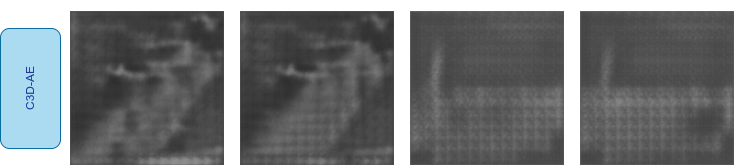

### Regularity plot for anomaly detection in frames

In [14]:
def get_the_gt(test_num):
    import re
    test_num -= 1

    # Read the contents of UCSDped1.m file
    with open(paths.test + '/UCSDped2.m', 'r') as file:
        file_contents = file.read()

    # Define a pattern to match the ground truth frames for the test_num
    pattern = r'TestVideoFile{[^}]+}\.gt_frame\s+=\s+\[(.*?)\];'

    # Find all matches for the pattern in the file_contents
    matches = re.findall(pattern, file_contents)

    # Get the ground truth frames for the specified test_num
    if test_num >= 0 and test_num < len(matches):
        gt_frames = matches[test_num]
    else:
        gt_frames = ""

    # print("Ground truth frames for test_num", test_num, ":", gt_frames)

    return gt_frames

def anomaly_detection(model_name, sequences, reconstructed, threshold, test_num):
    num_frames = sequences.shape[0]
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed[i])) for i in range(0,num_frames)])
    abnormality_score = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    regularity_score = 1.0 - abnormality_score
    
    # Identify anomalous frames
    regularity_score = regularity_score.tolist()
    anomaly_frames = []
    for i, score in enumerate(regularity_score):
        if score < threshold:
            anomaly_frames.append(i)

    # plot the regularity scores
    font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 12,
    }

    fig, ax = plt.subplots(figsize=(6,5))
    ax.plot(range(num_frames), regularity_score, 'b')
    for i in anomaly_frames:
        ax.plot(i, regularity_score[i], 'ro')
    ax.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    # get the ground truth frame label
    gt_frames = get_the_gt(test_num)
    ax.set_xlabel(f'Frame sequence (gt : [{gt_frames}])', fontdict=font)
    ax.set_ylabel('Regularity score (higher the better)', fontdict=font)
    ax.set_title("Regularity scores vs Frame sequence", fontdict=font)
    ax.legend(['Non-anomalous', 'Anomalous'], loc='upper right')
    plt.savefig(paths.regularity.format(test_num, model_name))
    plt.show()
    display.clear_output()
    
    
    return regularity_score, anomaly_frames

# Draw Regularity Graph
model_name = "3D_CNN_AE"
# test_num =  8 # param : {type:"integer"}
if choice == 'ped1':
    threshold = 0.99
    total_test = 36
else :
    threshold = 0.995
    total_test = 12


for test_num in range (1, total_test+1):
    sequences, reconstructed  = reconstruct_test(model_name=model_name, test_num="{0:03}".format(test_num))
    regularity_score, anomaly_frames = anomaly_detection(model_name, sequences, reconstructed, threshold, test_num)    

### Animation of regularity score in a test video

#### Creating a video from the frames of it.

In [15]:
def frames_to_video(image_input_path, video_output_path, img_format, fps=30):
    # Set the paths
    if not os.path.exists(os.path.dirname(video_output_path)):
        os.makedirs(os.path.dirname(video_output_path))

    # Get the list of images
    images = sorted(glob.glob(os.path.join(image_input_path, '*.{}'.format(img_format))))
    if not images:
        raise ValueError('No images found in {}'.format(image_input_path))

    # Read the first image to get the dimensions
    frame = cv2.imread(images[0])
    if frame is None:
        raise ValueError('Failed to read image: {}'.format(images[0]))
    height, width, layers = frame.shape

    # Create the video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(video_output_path, fourcc, fps, (width, height))
    if not video.isOpened():
        raise ValueError('Failed to open video writer')

    # Write the frames to the video
    for image in images:
        frame = cv2.imread(image)
        if frame is None:
            raise ValueError('Failed to read image: {}'.format(image))
        video.write(frame)

    # Release the video writer and destroy all windows
    video.release()
    cv2.destroyAllWindows()



In [17]:
# test_nums = [7, 18, 27, 19, 24] # ped1
test_nums = [2, 3, 4, 6, 9, 10] # ped2
for test_num in test_nums:
    frame_folder = paths.test + '/Test{0:03}'.format(test_num)
    video_output_path = paths.video + '/Test{0:03}/video.mp4'.format(test_num)

    frames_to_video(frame_folder, video_output_path, img_format='tif', fps=20)


#### Animation

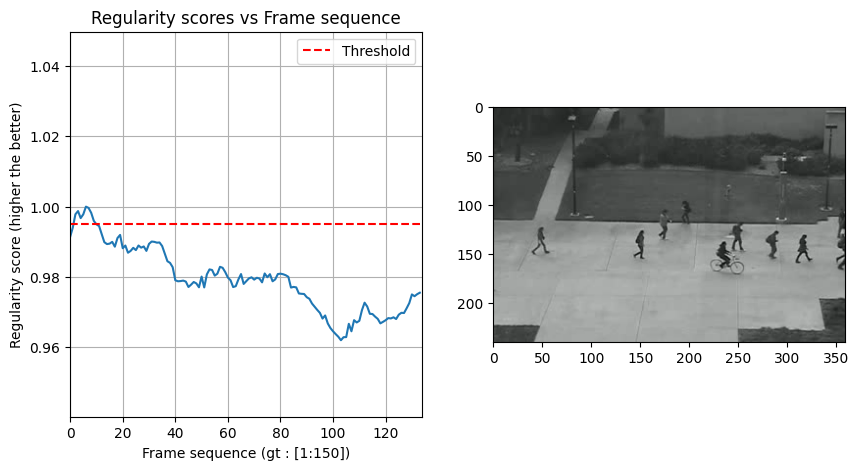

In [18]:
# test_nums = [7, 18, 27, 19, 24] # ped1
test_nums = [2, 3, 4, 6, 9, 10] # ped2
for test_num in test_nums:
    sequences, reconstructed  = reconstruct_test(model_name=model_name, test_num="{0:03}".format(test_num))
    regularity_score, anomaly_frames = anomaly_detection(model_name, sequences, reconstructed, threshold, test_num)

    # Define the paths
    video_path = paths.video + '/Test{0:03}/video.mp4'.format(test_num)
    # regularity_score_path = "path/to/regularity_score.npy"
    output_path = paths.video + '/Test{0:03}/animated_Graph.mp4'.format(test_num)

    # Load the video
    cap = cv2.VideoCapture(video_path)

    # Load the regularity score
    regularity_score = np.array(regularity_score)

    # Define the figure and axes for the plot and the video
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    line, = ax1.plot([], [])
    ax1.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    ax1.grid(True)
    # get the ground truth frame label
    gt_frames = get_the_gt(test_num)
    ax1.set_xlabel(f'Frame sequence (gt : [{gt_frames}])')
    ax1.set_ylabel('Regularity score (higher the better)')
    ax1.set_title("Regularity scores vs Frame sequence")
    ax1.legend(loc='upper right')

    img = ax2.imshow(cap.read()[1], cmap="gray")

    # Define the initialization function for the animation
    def init():
        ax1.set_xlim(0, regularity_score.shape[0])
        return line,

    # Define the update function for the animation
    def update(frame):
        _, frame_img = cap.read()
        line.set_data(range(frame+1), regularity_score[:frame+1])
        if frame == regularity_score.shape[0] - 1:
            cap.release()
        else:
            img.set_data(frame_img)
        return line, img

    # Create the animation
    ani = FuncAnimation(fig, update, frames=regularity_score.shape[0],
                                interval=20, blit=True, init_func=init)

    # Save the animation
    Writer = writers['ffmpeg']
    writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=1600)
    ani.save(output_path, writer=writer)


### AUC ROC curve

In [19]:
# paths = Path(choice='ped1')
# threshold = 0.96
y_true_all = []
y_pred_all = []
root_dir = "path/to/project/"
if choice == 'ped1' :
    history_dir = 'History/ped1'
    total_test = 36
    auc_list = [0]*total_test
else :
    history_dir = 'History/ped2'
    total_test = 12
    auc_list = [0]*total_test

strategy = tf.distribute.MirroredStrategy(devices=["/gpu:%d" % i for i in range(2)])
with strategy.scope():
    for num in range(1, total_test+1):
        gt_folder = paths.test + '/Test{0:03}_gt'.format(num)
        if not os.path.exists(gt_folder):
            # skip this test case if the "gt" folder does not exist
            continue
        
        # reconstruct the video frames for this test case
        sequences, reconstructed = reconstruct_test(model_name=model_name, test_num="{0:03}".format(num))
        error = sequences - reconstructed
        sz = sequences.shape[0]
        nb_frames = sz + 16
        ground_truth = [0]*nb_frames
        
        # read the ground truth for this test case
        for i in range(nb_frames):
            try:
                im = imageio.imread(gt_folder + '/{0:03}.bmp'.format(i+1))
            except (FileNotFoundError, IndexError):
                continue
            if im.max() == 255:
                ground_truth[i-1] = 1
        
        sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i], reconstructed[i])) for i in range(0, nb_frames-16)])
        sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
        sr = 1.0 - sa
        y_pred = [0]*sz
        for i in range(sz):
            if sr[i] < threshold:
                y_pred[i] = 1
        y_true = ground_truth[:-16]
        try:
            auc_score = roc_auc_score(y_true, y_pred)
        except ValueError:
            auc_score = 0
        display.clear_output()
        print("AUC of video (No :", num, ") = ", auc_score)
        auc_list[num-1] = auc_score
        y_true_all.extend(y_true)
        y_pred_all.extend(y_pred)
        data = [num, auc_score]
        with open(history_dir + f'/AUC_{model_name}.csv', 'a') as f:
            writer = csv.writer(f)
            writer.writerow(data)


lst = [x for x in auc_list if x > 0]
print("The mean of AUC: ", sum(lst) / len(lst))



AUC of video (No : 12 ) =  0
The mean of AUC:  0.5121717282704893


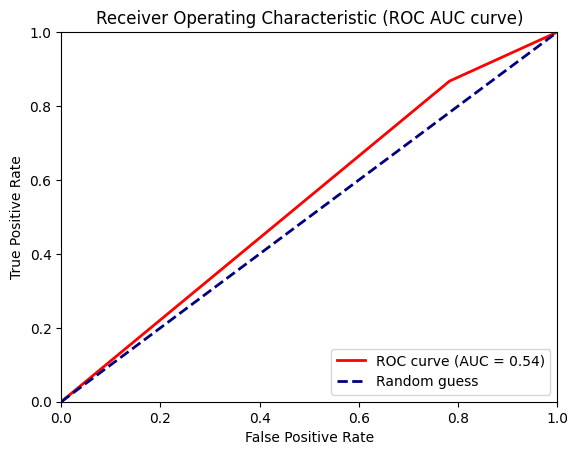

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# calculate the false positive rate (fpr) and true positive rate (tpr)
fpr, tpr, thresholds = roc_curve(y_true_all, y_pred_all)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC AUC curve)')
plt.legend(loc="lower right")
plt.savefig(paths.auc.format(model_name))
plt.show()


### Localization of the anomaly in the video

In [21]:
def compute_sum_of_squares(num: int, error: np.ndarray) -> np.ndarray:
    """
    Compute the sum of squares of the pixel values within a window of size (num, num) for each pixel in the frames
    of the input 'error' array : error = sequences-reconstructed_seq.

    Parameters:
    num (int): The size of the window.
    error (np.ndarray): The input array of frames.

    Returns:
    np.ndarray: An array containing the sum of squares for each pixel position in each frame.
    """

    num_frames, size_img = error.shape[0], error.shape[2]

    # Initialize the output array
    filtered_frames = np.zeros((num_frames, size_img - num, size_img - num))

    # Loop over each frame
    for t in range(num_frames):
        img = error[t][0]
        img = np.asarray(img.reshape(224, 224))

        # Compute the sum of squares for each pixel position in the current frame
        for i in range(size_img-num):
            for j in range(size_img-num):
                filtered_frames[t][i][j] = np.square(img[i:i+num, j:j+num]).sum()

    # Loop over the last 16 frames
    for t in range(1, 17):
        img = error[-1][-t]
        img = np.asarray(img.reshape(224, 224))

        # Compute the sum of squares for each pixel position in the current frame
        for i in range(size_img-num):
            for j in range(size_img-num):
                filtered_frames[num_frames - 17 + t][i][j] = np.square(img[i:i+num, j:j+num]).sum()

    # print(filtered_frames.shape)
    return filtered_frames


In [107]:
# ff = compute_sum_of_squares(16, error)
# ff

In [55]:
## This function that draw rectangles in anomaly position

def localize_anomalies(num, img, fil):
    result_path = paths.result+"/Test{0:03}/".format(num)
    input_frame_path = paths.test+'/Test{0:03}/{1}.tif'.format(num, img)
    output_frame_path = result_path + img + ".jpg"
    if not os.path.exists(os.path.dirname(output_frame_path)):
      os.makedirs(os.path.dirname(output_frame_path))
      
    img = cv2.imread(input_frame_path)
    image = cv2.resize(img,(224, 224))
    I=[]
    J=[]
    # Find coordinates of anomalies in filter array
    for i in range(208):
      for j in range(208):
        if (fil[j][i]) :
          I.append(i)
          J.append(j)

    # Overlay rectangles on image for each anomaly
    overlay = image.copy()
    for i in range (len(I)):
      start_point = (I[i], J[i])
      end_point = (I[i]+16, J[i]+16)

      # First we crop the sub-rect from the image
      cv2.rectangle(overlay, start_point, end_point, (0, 0, 200), -1)  # A filled rectangle

    # Apply transparency to overlay and save output image
    alpha = 0.4  # Transparency factor.
    localize_frames = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)
    print(output_frame_path)
    cv2.imwrite(output_frame_path, localize_frames)

In [ ]:
test_num = 2
sequences, reconstructed  = reconstruct_test(model_name=model_name, test_num="{0:03}".format(test_num))
error = sequences-reconstructed
num_frames = sequences.shape[0]
sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed[i])) for i in range(0,num_frames)])
abnormality_score = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
regularity_score = 1.0 - abnormality_score

# Compute the anomaly positions
fil = compute_sum_of_squares(16, error)
# fil

In [87]:
np.max(fil)

36.83292930607431

In [98]:
# Anomaly Localization
# test_nums = [7, 18, 27, 19, 24] # ped1
test_nums = [2, 3, 6, 9, 10] # ped2
for test_num in test_nums:
    # Select spatial threshold after which it will be detected as anomaly
    # s_threshold = 19 # ped1 param : {type:"slider", min:0, max:20, step:0.5}
    s_threshold = 18 # ped2 param : {type:"slider", min:0, max:20, step:0.5}
    # s_threshold = 25 # ped2 4 param : {type:"slider", min:0, max:20, step:0.5}
    path = paths.result+"/Test{0:03}/".format(test_num)

    sequences, reconstructed  = reconstruct_test(model_name=model_name, test_num="{0:03}".format(test_num))
    error = sequences-reconstructed
    num_frames = sequences.shape[0]
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed[i])) for i in range(0,num_frames)])
    abnormality_score = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    regularity_score = 1.0 - abnormality_score

    # Compute the anomaly positions
    fil = compute_sum_of_squares(16, error)
    anomaly_positions = fil > s_threshold
    for f in sorted(os.listdir(paths.test+"/Test{0:03}/".format(test_num))):
      if f[-3:] == "tif":
        if (int(f[0:3]) < num_frames-16) and (regularity_score[int(f[0:3])-1] < threshold):
          localize_anomalies(test_num, f[0:3], anomaly_positions[int(f[0:3])-1])
        else : 
          path = paths.result+"/Test{0:03}/".format(test_num)
          # print(path)
          img_path = path + f[0:3] + ".jpg"
          path = paths.test+'/Test{0:03}/{1}.tif'.format(test_num, f[0:3])
          img = cv2.imread(path)
          image = cv2.resize(img,(224, 224))
          cv2.imwrite(img_path, image)
    print("Anomaly localization is done successfully")

Loaded model
Loaded Test : 002
This video contains 164 frames
(164, 16, 224, 224, 1)
41/41 [==============================] - 6s 133ms/step
/mnt/db5ee27b-d60f-427d-a8d7-117198a38bb1/Supriyo/Dissertation works/Experiments/Video-AD/SIVAD/Trad_VAD_CNN/Results/ped2/Test002/001.jpg
/mnt/db5ee27b-d60f-427d-a8d7-117198a38bb1/Supriyo/Dissertation works/Experiments/Video-AD/SIVAD/Trad_VAD_CNN/Results/ped2/Test002/002.jpg
/mnt/db5ee27b-d60f-427d-a8d7-117198a38bb1/Supriyo/Dissertation works/Experiments/Video-AD/SIVAD/Trad_VAD_CNN/Results/ped2/Test002/003.jpg
/mnt/db5ee27b-d60f-427d-a8d7-117198a38bb1/Supriyo/Dissertation works/Experiments/Video-AD/SIVAD/Trad_VAD_CNN/Results/ped2/Test002/004.jpg
/mnt/db5ee27b-d60f-427d-a8d7-117198a38bb1/Supriyo/Dissertation works/Experiments/Video-AD/SIVAD/Trad_VAD_CNN/Results/ped2/Test002/005.jpg
/mnt/db5ee27b-d60f-427d-a8d7-117198a38bb1/Supriyo/Dissertation works/Experiments/Video-AD/SIVAD/Trad_VAD_CNN/Results/ped2/Test002/006.jpg
/mnt/db5ee27b-d60f-427d-a8d7-117

In [99]:
# test_nums = [7, 18, 27, 19, 24] # ped1
test_nums = [2, 3, 6, 9, 10] # ped2
for test_num in test_nums:
    output_localize_video = paths.video+'/Test{0:03}/Localize.mp4'.format(test_num)
    localize_frames = paths.result+"/Test{0:03}/".format(test_num)
    frames_to_video(localize_frames, output_localize_video, img_format='jpg', fps=20)